In [6]:
# google_trends_analysis.py
#
# Search Google Trends for a topic.
# Output:
# - Interest over time (weekly)
# - Interest per year (resampled)
# - Top 10 related topics and queries (if available)
#
# Requires: pip install pytrends pandas

from datetime import date
import pandas as pd
from pytrends.request import TrendReq

# -------------------------------
# CONFIG
# -------------------------------
SEARCH_TERM = "Ferrari Dino 246"
START_DATE = "2006-01-01"
END_DATE = date.today().isoformat()

# -------------------------------
# 1. Setup Pytrends connection
# -------------------------------
pytrends = TrendReq(hl="en-US", tz=360)

# -------------------------------
# 2. Get topic ID from suggestion list
# -------------------------------
suggestions = pytrends.suggestions(SEARCH_TERM)
if not suggestions:
    raise ValueError(f"No suggestions found for: {SEARCH_TERM}")

topic_id = suggestions[0]["mid"]
print(f"Using topic: {suggestions[0]['title']} ({topic_id})")

# -------------------------------
# 3. Build the query payload
# -------------------------------
timeframe = f"{START_DATE} {END_DATE}"
pytrends.build_payload([topic_id], timeframe=timeframe)

# -------------------------------
# 4. Fetch interest over time
# -------------------------------
iot = pytrends.interest_over_time().drop(columns=["isPartial"])
print("\nInterest over time (weekly):")
print(iot.head())

# -------------------------------
# 5. Resample to yearly interest
# -------------------------------
yearly = iot.resample("Y").mean().round(2)
yearly.index = yearly.index.year  # change to just year
print("\nInterest per year:")
print(yearly)

# -------------------------------
# 6. Fetch related topics & queries
# -------------------------------


def safe_related(call):
    try:
        return call()
    except (KeyError, IndexError):
        return {}


def safe_top(df_dict, field, n=10):
    data = df_dict.get(topic_id, {}).get(field)
    return (
        data.nlargest(n, "value") if isinstance(data, pd.DataFrame) else pd.DataFrame()
    )


rel_topics = safe_related(pytrends.related_topics)
rel_queries = safe_related(pytrends.related_queries)

top_topics = safe_top(rel_topics, "top")
top_queries = safe_top(rel_queries, "top")

# -------------------------------
# 7. Output related topics & queries
# -------------------------------
if not top_topics.empty:
    print("\nTop 10 Related Topics:")
    print(top_topics.reset_index(drop=True))
else:
    print("\nNo related topics returned.")

if not top_queries.empty:
    print("\nTop 10 Related Queries:")
    print(top_queries.reset_index(drop=True))
else:
    print("\nNo related queries returned.")

Using topic: Dino (/m/02swgd)


/home/ettore/projects/hackathons/MVA_hackathon_2025/vintage_ai/.venv/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/tmp/ipykernel_26272/1807033216.py:53: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = iot.resample("Y").mean().round(2)



Interest over time (weekly):
            /m/02swgd
date                 
2006-01-01         62
2006-02-01         50
2006-03-01         52
2006-04-01         56
2006-05-01         61

Interest per year:
      /m/02swgd
date           
2006      60.83
2007      75.00
2008      58.83
2009      45.50
2010      38.33
2011      36.83
2012      37.00
2013      41.50
2014      39.83
2015      45.00
2016      37.67
2017      53.67
2018      36.58
2019      34.67
2020      35.08
2021      33.00
2022      34.33
2023      30.67
2024      36.75
2025      28.17

No related topics returned.

No related queries returned.


In [10]:
from datetime import date
import pandas as pd
from pytrends.request import TrendReq


def fetch_trends_global(
    query: str, start_date: str = "2006-01-01", granularity: str = "weekly"
) -> pd.DataFrame:
    """
    Fetch global (worldwide) Google Trends interest over time (0-100) for a given query.

    Args:
        query (str): The search term or topic.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        granularity (str): One of 'weekly', 'monthly', or 'yearly' for resampling.

    Returns:
        pd.DataFrame: Time-indexed interest levels (0-100), or empty DataFrame on error.
    """
    try:
        end_date = date.today().isoformat()
        timeframe = f"{start_date} {end_date}"
        pytrends = TrendReq(hl="en-US", tz=360)

        suggestions = pytrends.suggestions(query)
        if not suggestions:
            return pd.DataFrame()

        topic_id = suggestions[0]["mid"]
        pytrends.build_payload([topic_id], timeframe=timeframe, geo="")  # Global

        iot = pytrends.interest_over_time()
        if iot.empty or "isPartial" not in iot.columns:
            return pd.DataFrame()

        series = iot.drop(columns="isPartial")[topic_id].rename("Global")

        # Resampling
        if granularity == "monthly":
            return series.resample("M").mean().round(2).to_frame()
        elif granularity == "yearly":
            return series.resample("Y").mean().round(2).to_frame()
        else:  # default: weekly
            return series.to_frame()

    except Exception as e:
        # Optionally log error: print(f"Error: {e}")
        return pd.DataFrame()

/home/ettore/projects/hackathons/MVA_hackathon_2025/vintage_ai/.venv/lib/python3.10/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/tmp/ipykernel_26272/3238007229.py:41: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  return series.resample("Y").mean().round(2).to_frame()


<Axes: title={'center': 'Ferrari Dino 246 Global Interest Over Time'}, xlabel='Date', ylabel='Interest (0-100)'>

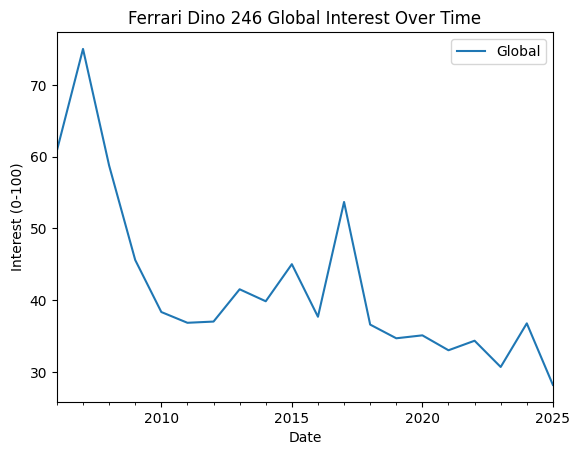

In [15]:
df = fetch_trends_global(
    "Ferrari Dino 246", start_date="2006-01-01", granularity="yearly"
)
df.plot(
    title="Ferrari Dino 246 Global Interest Over Time",
    ylabel="Interest (0-100)",
    xlabel="Date",
)